In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Required Imports

In [5]:
import tensorflow as tf
import keras
from tensorflow.keras.initializers import GlorotNormal
from keras import layers
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
import keras

def convolution_output_size(input_size, filter_size, stride):
  """Calculates the output size of a convolution operation.

  Args:
    input_size: A tuple of two integers (height, width).
    filter_size: A tuple of two integers (kernel_height, kernel_width).
    stride: A tuple of two integers (stride_height, stride_width).

  Returns:
    A tuple of two integers (output_height, output_width).
  """

  output_height = int((input_size[0] - filter_size[0]) // stride[0] + 1)
  output_width = int((input_size[1] - filter_size[1]) // stride[1] + 1)

  return (output_height, output_width)

input_size = (100, 100)
filter_size = (7, 5)
stride = (2, 1)

output_size = convolution_output_size(input_size, filter_size, stride)

print(output_size)

(47, 96)


### Read CSV Files & Split Train and Validation data

In [13]:
# Get train and test data
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

# Separate label information from training data
X = train.drop(['label'], axis = 1)
y = train['label']

# Normalize the traning data
X = X / 255.
test = test / 255.

# Reshape the input data for training
X = X.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

print("Train data shape"+str(X.shape))
print("Train label data shape"+str(y.shape))

# Split training and test data
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=50)

print("Training data shape"+str(X_train.shape))
print("Train label data shape"+str(y_train.shape))
print("Validation data shape"+str(X_validate.shape))
print("Validation label data shape"+str(y_validate.shape))


Train data shape(42000, 28, 28, 1)
Train label data shape(42000,)
Training data shape(33600, 28, 28, 1)
Train label data shape(33600,)
Validation data shape(8400, 28, 28, 1)
Validation label data shape(8400,)


### Train Model
* Created 4 convolution layers with elu activation function.
* After every CNN layer placed a batch normalization layer to keep the traning stable for dealing with vanishing/exploding gradients.
* After MaxPooling a dropout layer is kept to avoid overfitting while training.
* Finally create 2 dense layers to train the model to predict the digits.

In [14]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (7,7), padding='same', input_shape=[28, 28, 1]),
    keras.layers.ELU(),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64, (7,7), padding='same'),
    keras.layers.ELU(),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(128, (5,5), padding='same'),
    keras.layers.ELU(),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(256, (5,5), padding='same'),
    keras.layers.ELU(),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dense(64, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        1600      
                                                                 
 elu_4 (ELU)                 (None, 28, 28, 32)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)       

### Image alteration to increase model accuracy
* Explored the image modification in keras and inclued basic image alterations of zooming, rotation and shifting based on width/height.

In [15]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

### Learning Rate Scheduler
Explored learning rate modifications while model is traning and implemented the Reduce LR on Plateau provided by keras.

In [16]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.5,           # Reduce the learning rate by half
    patience=5,           # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,            # Set to 1 for logging updates
    min_lr=1e-6           # Minimum learning rate
)

### Model Execution
* Created a model checkpoint to get the model with low validation loss.
* Used Adamax for model optimizer.
* Executing with 50 epochs to get the best model with low validation loss.

In [17]:
# Created a checkpoint with callback to get the best model
checkpoint_cb = keras.callbacks.ModelCheckpoint("keras_model.h5", save_best_only=True, verbose=1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adamax(learning_rate=0.01),
             metrics=["accuracy"])
history = model.fit(datagen.flow(X_train, y_train, batch_size=256), epochs=50,
                    validation_data=(X_validate, y_validate),
                   callbacks = [checkpoint_cb, lr_scheduler])
new_model = keras.models.load_model("keras_model.h5")

Epoch 1/50
  1/132 [..............................] - ETA: 2:03 - loss: 3.7921 - accuracy: 0.1055

2023-10-21 14:17:37.017736: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


132/132 [==============================] - ETA: 0s - loss: 0.9381 - accuracy: 0.7561
Epoch 1: val_loss improved from inf to 6.81214, saving model to keras_model.h5
132/132 [==============================] - 12s 87ms/step - loss: 0.9381 - accuracy: 0.7561 - val_loss: 6.8121 - val_accuracy: 0.1154 - lr: 0.0100
Epoch 2/50
132/132 [==============================] - ETA: 0s - loss: 0.2174 - accuracy: 0.9322
Epoch 2: val_loss improved from 6.81214 to 3.80334, saving model to keras_model.h5
132/132 [==============================] - 11s 83ms/step - loss: 0.2174 - accuracy: 0.9322 - val_loss: 3.8033 - val_accuracy: 0.4015 - lr: 0.0100
Epoch 3/50
132/132 [==============================] - ETA: 0s - loss: 0.1535 - accuracy: 0.9529
Epoch 3: val_loss improved from 3.80334 to 0.47525, saving model to keras_model.h5
132/132 [==============================] - 11s 84ms/step - loss: 0.1535 - accuracy: 0.9529 - val_loss: 0.4753 - val_accuracy: 0.8614 - lr: 0.0100
Epoch 4/50
132/132 [====================

### Loss and Accuracy results from trained model

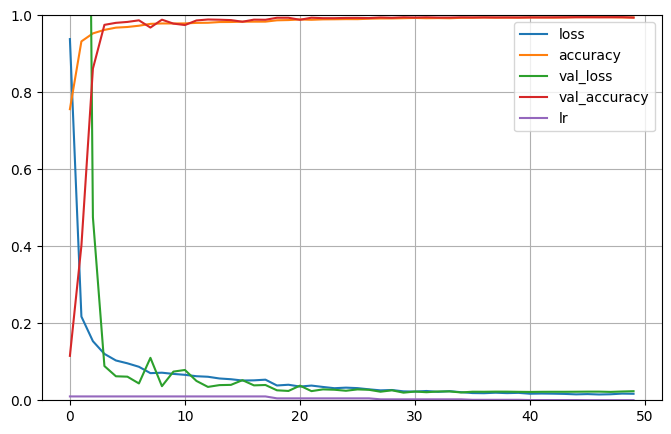

In [18]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
plt.show()

In [19]:
mse_test = model.evaluate(X_validate, y_validate)
mse_test = new_model.evaluate(X_validate, y_validate)

263/263 [==============================] - 1s 3ms/step - loss: 0.0198 - accuracy: 0.9948


### Model Accuracy with test data

In [20]:
submission = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")
predictions = new_model.predict(test)
from IPython.display import HTML
x_class = np.argmax(predictions, axis=1)
submission['Label'] = x_class
submission.to_csv('/kaggle/working/submission.csv', index=False)
def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='submission.csv')

875/875 [==============================] - 2s 2ms/step
